# Úkol č. 3 - Segmentace zákazníků e-shopu
**Deadline úkolu je uveden na [course pages](https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html).**

Jednou z důležitých aplikací shlukování je **segmentace zákazníků** (angl. **customer segmentation**). 

Předpokládejme, že máme následující obchodní údaje o prodejích (resp. nákupech z pohledu zákazníků):
TransactionID - ID nákupu,
CustomerID - ID zákazníka, 
Date - datum nákupu, 
Total - celková cena nákupu.

Chceme najít segmenty zákazníků, kteří se chovají podobně. K tomu je dobré informace z jednotlivých nákupů pro individuální zákazníky agregovat. Tj. získat pro každého zákazníka jeden řádek.

Populárním přístupem je **RFM**, což znamená:

- **R**ecency: Počet dnů od posledního nákupu (poslední datum v datasetu pro daného zákazníka).
- **F**requency: Počet nákupů. Občas se vynechávají zákazníci s jediným nákupem. Pro jednoduchost je zde ale necháme.
- **M**onetary: Celková suma, kterou daný zákazník utratil.

## Zdroj dat
Budeme pracovat s daty z jednoho (skoro) vymyšleného eshopu, která jsou v přiloženém souboru `eshop.csv`.

## Pokyny k vypracování

Ve všech bodech zadání uvažujte aktuální datum jako datum poslední transakce (19. 12. 2015), nikoliv dnešek. Tváříme se, že jde o aktuální data.

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
- Vytvořte `rfm` data frame, kde každý řádek odpovídá jednomu zákazníkovi a sloupce (příznaky) jsou uvedené výše.
- Pomocí algoritmu `K-means` proveďte shlukování. Nějakým způsobem také odhadněte nejlepší počet shluků (podrobně vysvětlete).
- Zabývejte se vlivem přeškálování dat (standardizace příznaků). Tj. určete, zda je přeškálování vhodné, a proveďte ho.
- Interpretujte jednotlivé shluky. Použijte získané shluky k odlišení "superstar" zákazníků (vysoká monetary, vysoká frequency a nízká recency) od nezajímavých  zákazníků (vysoká recency, nízká frequency, nízká monetary).

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
- (až +4 body) Proveďte analýzu vytvořených shluků pomocí metody silhouette (https://en.wikipedia.org/wiki/Silhouette_(clustering)).
- (až +4 body) Zkuste provést to samé s modifikovanou verzí **RFM**, kde Recency = "maximum počtu měsíců od posledního nákupu a čísla 1", Frequency = "maximum počtu nákupů daného zákazníka v posledních 12 měsících a čísla 1", Monetary = "Nejvyšší hodnota nákupu daného zákazníka". Porovnejte s původním přístupem.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte Jupyter Notebook.
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni.

In [154]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
# from kneed import KneeLocator
from sklearn.metrics import silhouette_score


### Processing data


In [155]:
data = pd.read_csv("eshop.csv")
data.head()

,Customer ID,Date,Subtotal,Country
0,34,6/21/2007,86.0,Czech Republic
1,38,6/27/2007,38.4,Czech Republic
2,47,7/2/2007,53.5,Slovakia
3,61,7/14/2007,7.0,Czech Republic
4,78,7/21/2007,55.5,Czech Republic


In [156]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22408 entries, 0 to 22407
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Customer ID  22408 non-null  int64  
 1   Date         22408 non-null  object 
 2   Subtotal     22408 non-null  float64
 3   Country      22405 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 700.4+ KB


In [157]:
sorted_data = data.sort_values(by="Customer ID")
sorted_data["ID_for_frequency"] = sorted_data['Customer ID']

last_transaction = dt.datetime(2015,12,19)
sorted_data.Date = pd.to_datetime(sorted_data.Date)

grouped_data = sorted_data.groupby('Customer ID').agg(
         {'Date': lambda x: (last_transaction - x.max()).days,
          'ID_for_frequency': lambda x: len(x), 
          'Subtotal': lambda x: x.sum()})
    
grouped_data['Date'] = grouped_data['Date'].astype(int)

rfm_table = pd.DataFrame(columns = ['Recency','Frequency','Monetary'])
rfm_table['Monetary'] = grouped_data['Subtotal']
rfm_table['Frequency'] = grouped_data['ID_for_frequency']
rfm_table['Recency'] = grouped_data['Date']

rfm_table


,Recency,Frequency,Monetary
Customer ID,,,
7,311,3,15.54
9,3050,1,13.20
30,3025,1,36.20
34,3103,1,86.00
38,3097,1,38.40
...,...,...,...
15356,1,1,31.87
15357,1,1,6.10
15358,1,1,153.23


### Vizualizace dat v 3D

In [158]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.collections.PathCollection.legend_elements
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
def show_distribution(data, c = 'green', figsize=(10,10)):
    fig = plt.figure(figsize=figsize)
    ax = Axes3D(fig)

    ax.scatter(data[:,0], data[:,1], data[:,2], c=c, cmap='brg', s=75, alpha=0.5, edgecolors='whitesmoke')
    ax.set_xlabel('Recency')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('Monetary')

    plt.show()

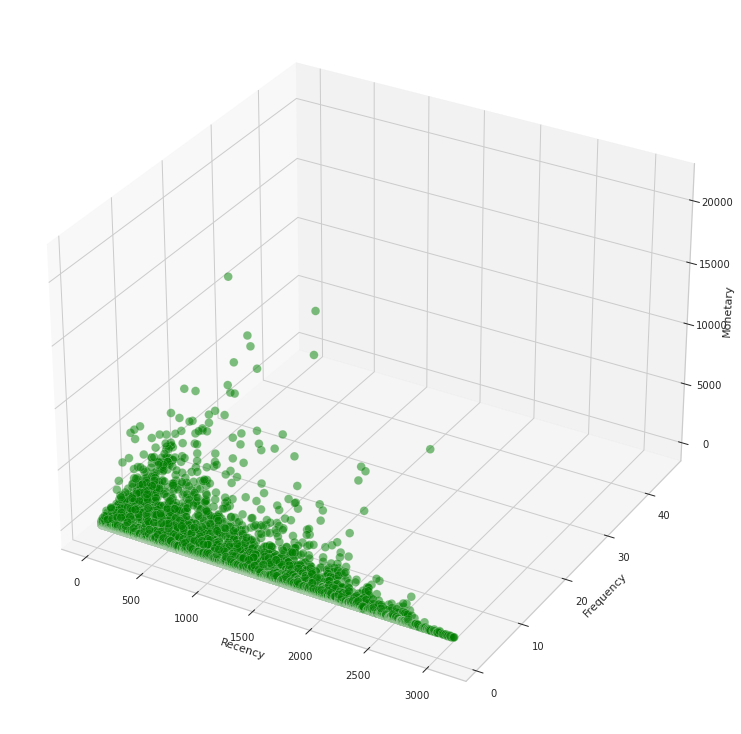

In [159]:
rfm_table_np = rfm_table.to_numpy()
show_distribution(rfm_table_np)

### Najdeme optimalni cislo clasteru

In [160]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

def find_best_k(data):
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(1,25))

    visualizer.fit(data)
    visualizer.show()
    return visualizer.elbow_value_

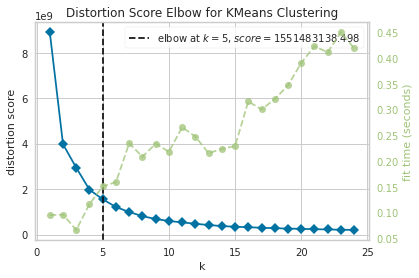

In [161]:
k_elbow = find_best_k(rfm_table_np)

## KMeans: Silhouette analysis

Provedením Silhouette analysis lze získat více informací o klastrech, jako je vzdálenost separace, velikost klastru, průměrné skóre siluety. To může být užitečné při určování optimálního k a při studiu výsledných klastrů.

In [162]:
import matplotlib.cm as cm

from sklearn.metrics import silhouette_samples, silhouette_score

def silhouette_analysis(data, range_n_clusters=range(2, 10), visualize=True):
    result = {}
    best_cluster_n = min(range_n_clusters)
    
    for n_clusters in range_n_clusters:
        if visualize: 
            fig = plt.figure(figsize=(25, 7))
            ax1 = fig.add_subplot(1, 2, 1)
            ax1.set_xlim([-0.1, 1])
            ax1.set_ylim([0, len(data) + (n_clusters+1)*100])

        clusterer = KMeans(n_clusters=n_clusters, random_state=1)
        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)        
        result[n_clusters] = silhouette_avg
        if result[best_cluster_n] < silhouette_avg: best_cluster_n = n_clusters
        sample_silhouette_values = silhouette_samples(data, cluster_labels)
        if visualize: 
            print(f'{n_clusters = }, stredni silhouette_score je : {silhouette_avg}')
            y_lower = 10
            for i in range(n_clusters):
                ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
                ith_cluster_silhouette_values.sort()
                size_cluster_i = ith_cluster_silhouette_values.shape[0]
                y_upper = y_lower + size_cluster_i
                color = cm.nipy_spectral(float(i) / n_clusters)
                ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
                ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
                y_lower = y_upper + 10

            ax1.set_title('Silhouette plot pro různé klastry.')
            ax1.set_xlabel('hodnoty koeficientů silhouette')
            ax1.set_ylabel('Cluster label')

            ax1.axvline(x=silhouette_avg, color='red', linestyle='--')

            ax1.set_yticks([])
            ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

            colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

            plt.suptitle((f'Silhouette analyza z {n_clusters = }'), fontsize=14, fontweight='bold')

    if visualize: plt.show()
    
    return best_cluster_n, result

Analýza ukazuje, že nejvyšší score získá k = 5, ale je vidět, že separace mezi shluky nejsou příliš výrazné. Klastry 3 a 4 jsou ve srovnání s jinými klastry (skládají se z odlehlých hodnot) malé a jsou blízko nebo pod průměrným skóre klastru.

n_clusters = 3, stredni silhouette_score je : 0.49331082934113596
n_clusters = 4, stredni silhouette_score je : 0.5081147721116864
n_clusters = 5, stredni silhouette_score je : 0.5210334149099141
n_clusters = 6, stredni silhouette_score je : 0.4771093137987031


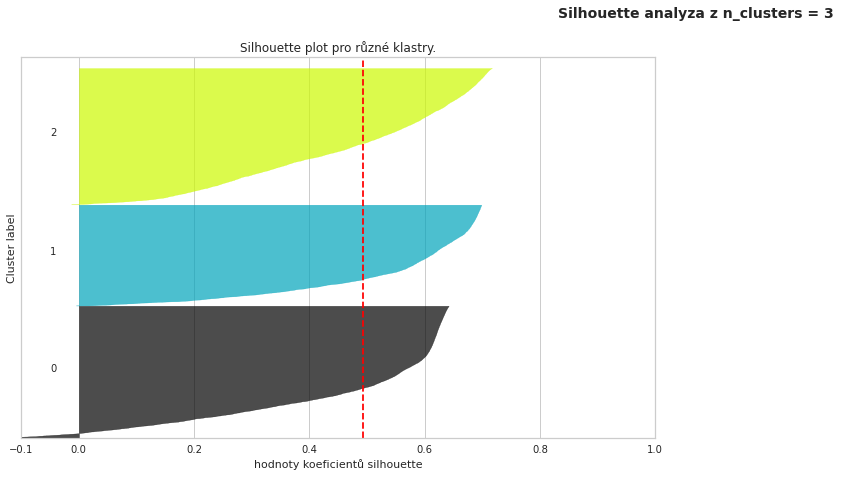

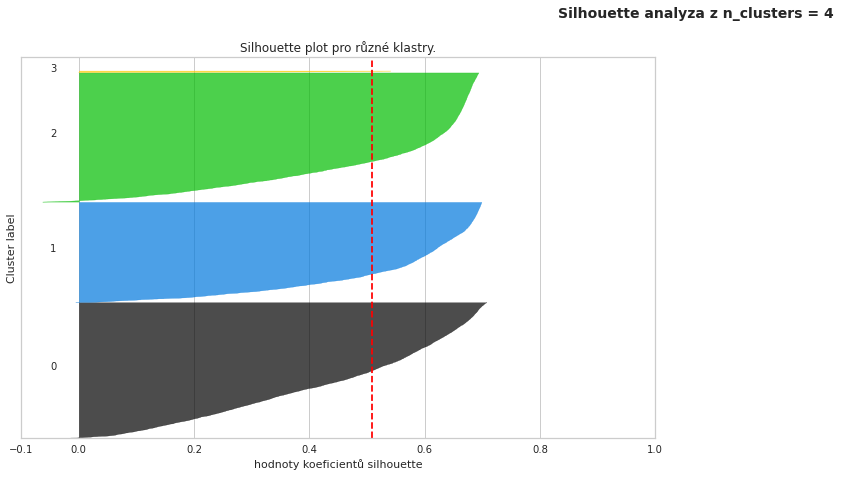

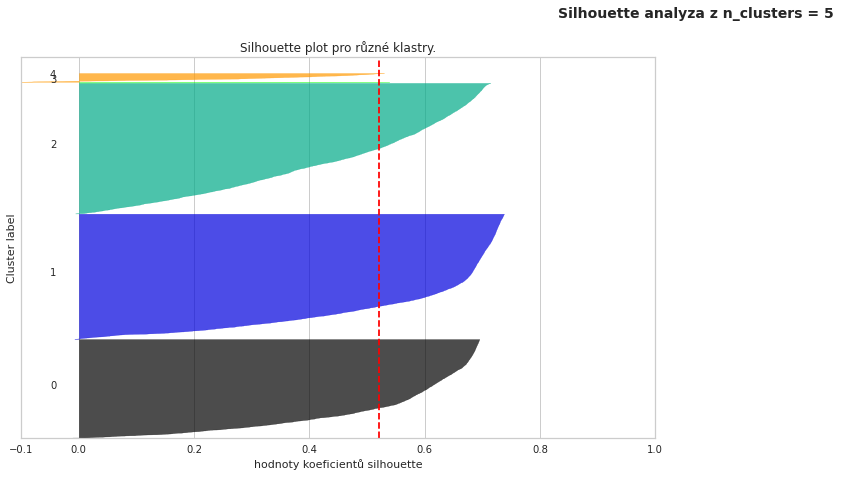

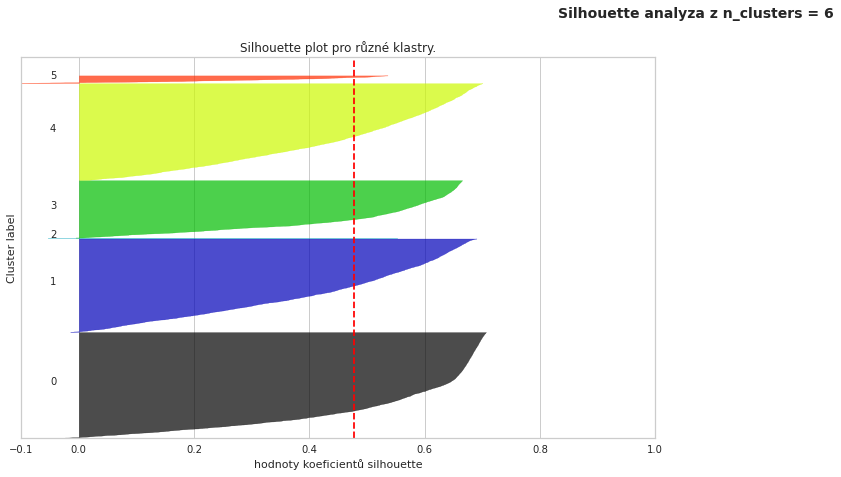

In [163]:
k_silh, res = silhouette_analysis(rfm_table_np, range(k_elbow - 2, k_elbow + 2))

### Preskalovani dat
rfm_table obsahuje ciselne hodnoty Recency, Frequency, Monetary a napriklad Monetary vzdy ma hodnoty vetsi nez Frequency a presto nas algoritmus by resil ze cena je dulezitejsi nez pocet. Aby tohoto se nestalo musime preskalovat daty do stejneho meritka. Pouziju standartization scale z cviceni.

In [164]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(rfm_table)

rfm_table_nm = pd.DataFrame(data=scaled_features, columns=["Recency" ,"Frequency","Monetary"])
rfm_table_nm.sort_values(by="Frequency")

rfm_table_nm

,Recency,Frequency,Monetary
0,-1.089608,0.623559,-0.344020
1,2.680430,-0.371483,-0.349759
2,2.646019,-0.371483,-0.293349
3,2.753381,-0.371483,-0.171209
4,2.745122,-0.371483,-0.287953
...,...,...,...
12824,-1.516301,-0.371483,-0.303969
12825,-1.516301,-0.371483,-0.367172
12826,-1.516301,-0.371483,-0.006320
12827,-1.517677,-0.371483,-0.335166


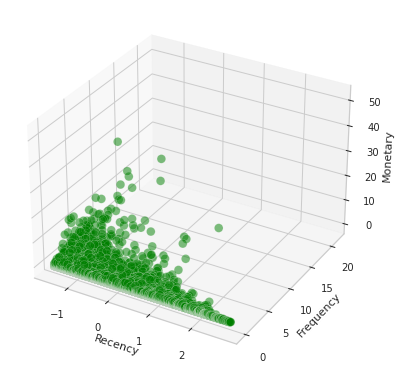

In [165]:
rfm_table_nm_np=rfm_table_nm.to_numpy()
show_distribution(rfm_table_nm_np, figsize=(5,5))

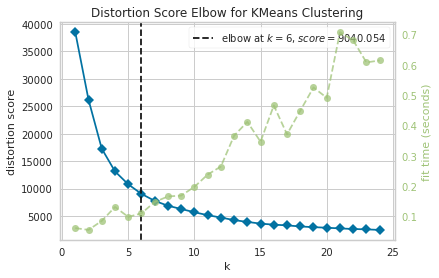

In [166]:
k_elbow = find_best_k(rfm_table_nm_np)

n_clusters = 4, stredni silhouette_score je : 0.48286984542745764
n_clusters = 5, stredni silhouette_score je : 0.48925237618054285
n_clusters = 6, stredni silhouette_score je : 0.4190369315251871
n_clusters = 7, stredni silhouette_score je : 0.42142450232680345


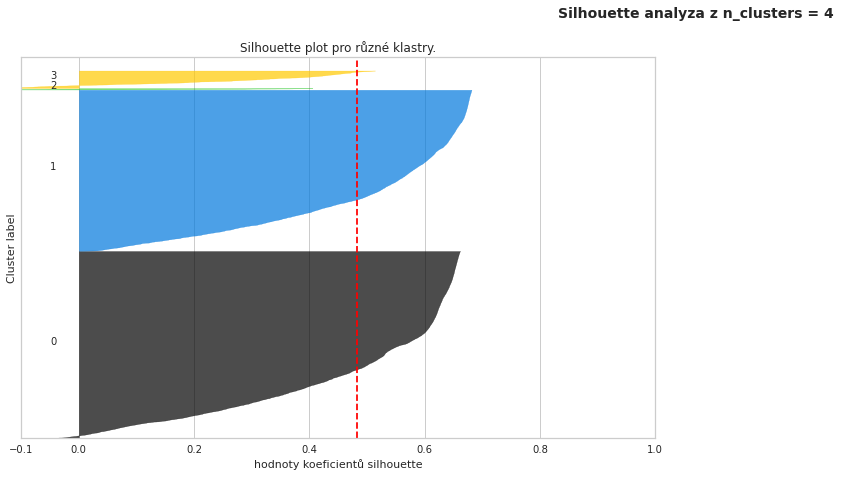

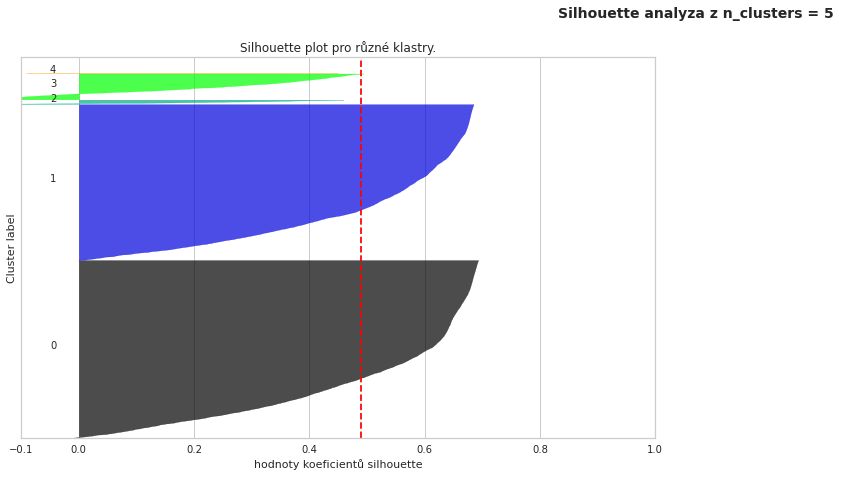

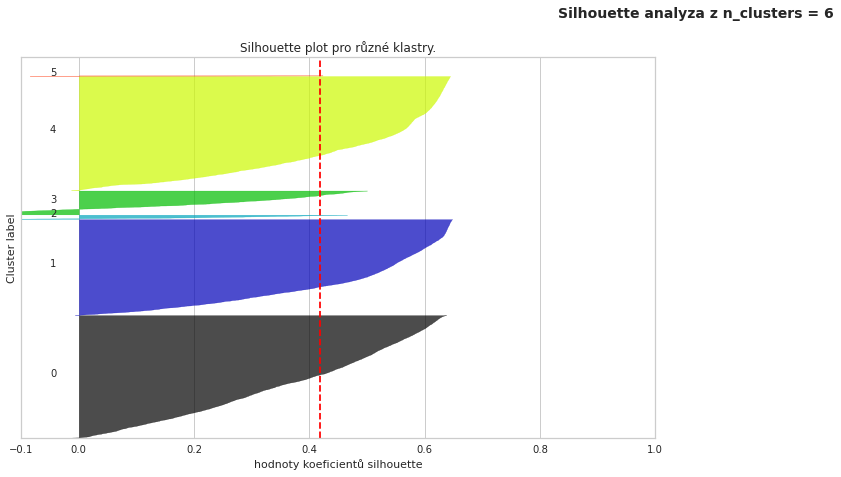

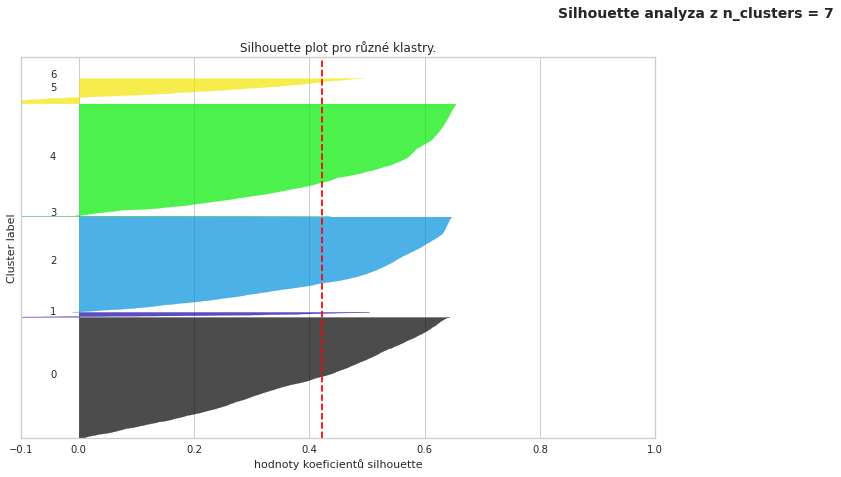

In [167]:
k_silh, res = silhouette_analysis(rfm_table_nm_np, range(k_elbow - 2, k_elbow + 2))

Tady je videt, ze silhouette_score je maximalne pri k=5, atejne jak i do normalizace, takze snizime pocet klasteru do 5.

### Shlukovani
Pomoci algotithmu KMeans provedeme zhlukovani

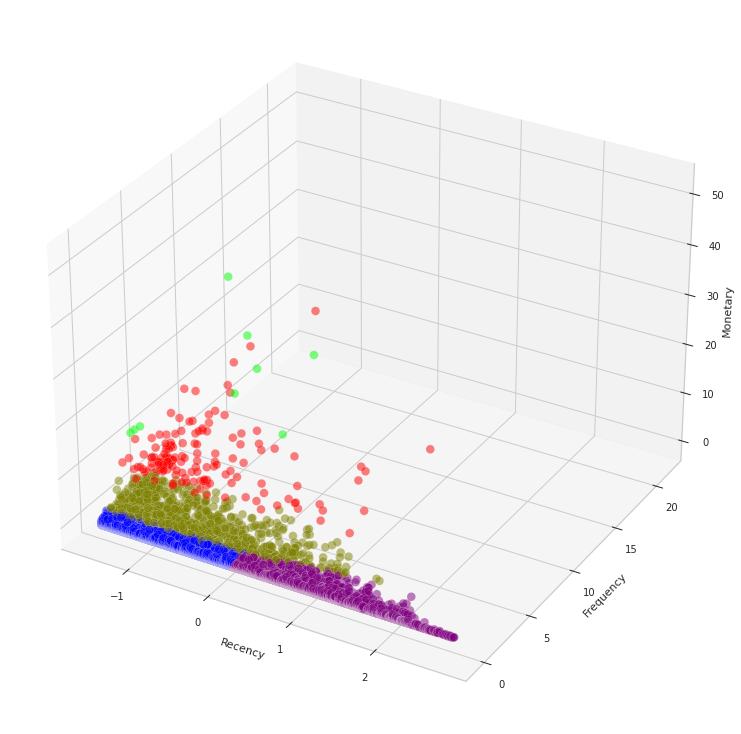

In [168]:
kmeans_rfm = KMeans(n_clusters = k_silh, random_state = 1).fit(rfm_table_nm_np)
show_distribution(rfm_table_nm_np, kmeans_rfm.labels_)

In [169]:
rfm_table_nm.describe()

,Recency,Frequency,Monetary
count,1.282900e+04,1.282900e+04,1.282900e+04
mean,-7.089366e-17,-5.317024e-17,-1.107713e-17
std,1.000039e+00,1.000039e+00,1.000039e+00
min,-1.517677e+00,-3.714828e-01,-3.792392e-01
25%,-8.900258e-01,-3.714828e-01,-3.035516e-01
50%,-5.591010e-02,-3.714828e-01,-2.231795e-01
75%,7.960992e-01,1.260381e-01,-3.015893e-02
max,2.753381e+00,2.151944e+01,5.208508e+01


### Interpretace jednotlivych shluku

Použijme získané shluky k odlišení "superstar" zákazníků (vysoká monetary, vysoká frequency a nízká recency) od nezajímavých zákazníků (vysoká recency, nízká frequency, nízká monetary).


In [170]:
cluster_table = rfm_table_nm
rfm_table_nm['cluster'] = kmeans_rfm.labels_
groups = cluster_table.groupby('cluster')
clusters = pd.DataFrame(data = {'Recency':   groups['Recency'].mean(),
                                'Frequency': groups['Frequency'].mean(),
                                'Monetary':  groups['Monetary'].mean()})

clusters


,Recency,Frequency,Monetary
cluster,,,
0,-0.725337,-0.202519,-0.140747
1,0.970279,-0.250907,-0.176672
2,-1.029256,6.102923,4.487845
3,-0.683297,1.847177,1.066676
4,-0.694726,5.211808,22.912657


In [171]:
cluster_table.describe()

,Recency,Frequency,Monetary,cluster
count,1.282900e+04,1.282900e+04,1.282900e+04,12829.000000
mean,-7.089366e-17,-5.317024e-17,-1.107713e-17,0.667550
std,1.000039e+00,1.000039e+00,1.000039e+00,0.824813
min,-1.517677e+00,-3.714828e-01,-3.792392e-01,0.000000
25%,-8.900258e-01,-3.714828e-01,-3.035516e-01,0.000000
50%,-5.591010e-02,-3.714828e-01,-2.231795e-01,1.000000
75%,7.960992e-01,1.260381e-01,-3.015893e-02,1.000000
max,2.753381e+00,2.151944e+01,5.208508e+01,4.000000


In [172]:
clusters_index=clusters
clusters_index['Superstar score'] = - clusters_index['Recency'] + clusters_index['Frequency'] + clusters_index['Monetary']
clusters_index['Trash score'] = clusters_index['Recency'] - clusters_index['Frequency'] - clusters_index['Monetary']
superstars = rfm_table_nm[ rfm_table_nm['cluster'] ==  clusters_index['Superstar score'].idxmax()]
trash      = rfm_table_nm[ rfm_table_nm['cluster'] ==  clusters_index['Trash score']    .idxmax()]

og_superstars = rfm_table.iloc[superstars.index]
og_trash = rfm_table.iloc[trash.index]
display(clusters)

,Recency,Frequency,Monetary,Superstar score,Trash score
cluster,,,,,
0,-0.725337,-0.202519,-0.140747,0.382071,-0.382071
1,0.970279,-0.250907,-0.176672,-1.397858,1.397858
2,-1.029256,6.102923,4.487845,11.620024,-11.620024
3,-0.683297,1.847177,1.066676,3.597150,-3.597150
4,-0.694726,5.211808,22.912657,28.819191,-28.819191


In [173]:
superstars.head()

,Recency,Frequency,Monetary,cluster
2929,0.153307,4.603727,17.902287,4
3601,-0.108214,1.618601,52.085079,4
3930,-0.450945,13.061583,17.250996,4
4803,-0.938201,11.071499,15.315100,4
4966,-0.183918,2.613643,27.646123,4


In [174]:
trash.head()

,Recency,Frequency,Monetary,cluster
1,2.680430,-0.371483,-0.349759,1
2,2.646019,-0.371483,-0.293349,1
3,2.753381,-0.371483,-0.171209,1
4,2.745122,-0.371483,-0.287953,1
5,1.829797,-0.371483,-0.336760,1


In [175]:
print("Shluk superstar zákazníků (vysoká monetary, vysoká frequency a nízká recency) je shluk #", clusters['Superstar score'].idxmax())
display(og_superstars.head())
print("Shluk nezajímavých zákazníků zákazníků (vysoká recency, nízká frequency, nízká monetary) je shluk #", clusters['Trash score'].idxmax())
display(og_trash.head())



Shluk superstar zákazníků (vysoká monetary, vysoká frequency a nízká recency) je shluk # 4


,Recency,Frequency,Monetary
Customer ID,,,
4148,1214,11,7455.08
4912,1024,5,21392.38
5291,775,28,7189.53
6356,421,24,6400.21
6544,969,7,11427.92


Shluk nezajímavých zákazníků zákazníků (vysoká recency, nízká frequency, nízká monetary) je shluk # 1


,Recency,Frequency,Monetary
Customer ID,,,
9,3050,1,13.2
30,3025,1,36.2
34,3103,1,86.0
38,3097,1,38.4
41,2432,1,18.5
